# RoBERTa_CLOTH

## 綁定雲端硬碟

如果用上面的方式下載了DGen資料集，這步驟可以跳過

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/ML

/content/drive/My Drive/ML


In [3]:
ls -l

total 8
drwx------ 2 root root 4096 Mar 12 13:21 datasets/
drwx------ 2 root root 4096 Mar 12 13:21 models/


## 引用相關套件

In [4]:
from tqdm.notebook import tqdm
import json
import re
import os

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 資料預處理

### 資料集處理方式

#### 三個錯誤 + SEP + 正確選項 (CLOTH)

In [6]:
# 三個錯誤 + SEP + 正確選項
en2num = {"A": 0, "B": 1, "C": 2, "D": 3}

input_list = list()
label_list = list()

for tv in ["train", "valid"]:
  tv_path = os.path.join(r"./datasets/CLOTH", tv)
  for grade in ["high", "middle"]:
    grade_path = os.path.join(tv_path, grade)
    # print(grade_path)

    files = os.listdir(grade_path)
    # print(files)

    for file in tqdm(files):     
      full_path = os.path.join(grade_path, file)
      # print(full_path)

      if not file.endswith(".json"):
        continue
      
      with open(full_path, "r") as f:
        dataset = json.load(f)

      sents = nltk.sent_tokenize(dataset["article"])
      options = dataset["options"]
      answers = dataset["answers"]

      i = 0
      for sent in sents:
        # print(sent)
        blank_num = sent.count("_")
        blank_texts = sent.split("_")
        for j in range(blank_num):
          input_text = ""
          label_text1 = ""
          label_text2 = ""
          label_text3 = ""
          k = 0
          for blank_text in blank_texts:
            if k == blank_num:
              answer_index = answer_index = en2num[answers[i+j]]
              answer = options[i+j][answer_index]

              # masked
              input_text = input_text + blank_text + " </s> " + answer
              input_list.append(input_text)
              input_list.append(input_text)
              input_list.append(input_text)

              # 錯誤選項
              label_text1 = label_text1 + blank_text + " </s> " + answer
              label_list.append(label_text1)
              label_text2 = label_text2 + blank_text + " </s> " + answer
              label_list.append(label_text2)
              label_text3 = label_text3 + blank_text + " </s> " + answer
              label_list.append(label_text3)

              # print(input_text)
              # print(label_text)
              # print("-"*50)

              break
            
            # 得到ans和dis的索引值
            ans_index = en2num[answers[i+k]]
            dis_indexs = [0, 1, 2, 3]
            dis_indexs.remove(ans_index)
            # print(ans_index)
            # print(dis_indexs)
            
            if k == j:  # 要被mask的
              input_text = input_text + blank_text + "<mask>"
              label_text1 = label_text1 + blank_text + options[i+k][dis_indexs[0]]
              label_text2 = label_text2 + blank_text + options[i+k][dis_indexs[1]]
              label_text3 = label_text3 + blank_text + options[i+k][dis_indexs[2]]
            else: # 其他不是被mask的
              ans = options[i+k][ans_index]
              input_text = input_text + blank_text + ans
              label_text1 = label_text1 + blank_text + ans
              label_text2 = label_text2 + blank_text + ans
              label_text3 = label_text3 + blank_text + ans
            
            # print("options:", options[i+k])
            # print("ans_index:", ans_index)
            # print("dis_index:", dis_index)
              
            k += 1
            
        i += blank_num
      
  #     break
  #   break
  # break

  0%|          | 0/3172 [00:00<?, ?it/s]

  0%|          | 0/2341 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

### 資料集長度

* CLOTH: 263751

In [7]:
print(len(input_list))
print(len(label_list))

263751
263751


In [8]:
print(input_list[:10])
print(label_list[:10])

['A young man with his  <mask>  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. </s> wife', 'A young man with his  <mask>  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. </s> wife', 'A young man with his  <mask>  was standing nearby and said to the old man, "You old fashioned people read only the Ramayana all the time. </s> wife', 'Do you not have any other book to  <mask>  ? </s> read', 'Do you not have any other book to  <mask>  ? </s> read', 'Do you not have any other book to  <mask>  ? </s> read', 'The old man continued to read and smiled without any  <mask>  to the young man. </s> reply', 'The old man continued to read and smiled without any  <mask>  to the young man. </s> reply', 'The old man continued to read and smiled without any  <mask>  to the young man. </s> reply', 'Soon, the train  <mask>  . </s> arrived']
['A young man with his  son  was standing nearb

## RoBERTa fine-tune

使用 [roberta-base](https://huggingface.co/roberta-base) 預訓練模型，加上克漏字資料微調。

In [10]:
!pip install transformers datasets

In [11]:
MAX_LENGTH = 64
BATCH_SIZE = 64
EPOCH = 1
LEARNING_RATE = 0.0001

### 建立Dataset

In [12]:
data_dic = {"input": input_list, "label": label_list}

In [13]:
from datasets import Dataset

dataset = Dataset.from_dict(data_dic)

In [14]:
print(len(dataset))

263751


### 建立DataLoader

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### 微調模型

In [16]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

cuda:0


max_len
* CLOTH: 250
* DGen: 215

In [ ]:
max_len = 0

# For every sentence...
for input in input_list:
    # Tokenize the text and add `[CLS]` and `</s>` tokens.
    input_ids = tokenizer.encode(input, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  250


In [ ]:
!nvidia-smi

Wed Mar 23 12:55:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |  11353MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gc
import torch

model = None
gc.collect()
torch.cuda.empty_cache()

In [17]:
# 進度條
num_training_steps = EPOCH * len(train_loader)
progress_bar = tqdm(range(num_training_steps))

# 開始訓練
loss_history = []
for epoch in range(EPOCH):
  for batch in train_loader:
    inputs = tokenizer(batch["input"], truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")
    labels = tokenizer(batch["label"], truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")["input_ids"]
    # print(inputs)
    # print(labels)
    output = model(**inputs.to(device), labels=labels.to(device))
    optimizer.zero_grad()
    loss = output.loss
    logits = output.logits
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    progress_bar.update(1)
  
  print(f"[epoch {epoch+1}] loss: {loss.item()}")

  0%|          | 0/4122 [00:00<?, ?it/s]

[epoch 1] loss: 0.23416100442409515


In [18]:
print(loss_history)
print(len(loss_history))

[17.51329803466797, 10.222380638122559, 9.742937088012695, 10.058903694152832, 9.324771881103516, 9.194750785827637, 9.122148513793945, 8.99184799194336, 8.460397720336914, 9.04269027709961, 8.163168907165527, 8.673477172851562, 8.284425735473633, 7.508147716522217, 8.086718559265137, 7.6051554679870605, 8.127086639404297, 7.434971332550049, 7.014443397521973, 6.644243240356445, 7.01953649520874, 6.9755353927612305, 6.58667516708374, 6.317573547363281, 6.738511085510254, 6.413153171539307, 6.019469261169434, 5.727799892425537, 5.535501956939697, 5.59490442276001, 5.448458194732666, 5.235904693603516, 5.6378679275512695, 5.139645099639893, 5.288377285003662, 5.061162948608398, 4.972124099731445, 4.717527389526367, 4.9766693115234375, 4.703064918518066, 4.5228800773620605, 4.893592357635498, 4.489910125732422, 4.274604320526123, 4.238157749176025, 4.316525459289551, 4.2679667472839355, 3.746105670928955, 3.7646007537841797, 3.5978174209594727, 3.5619795322418213, 3.695460319519043, 3.547

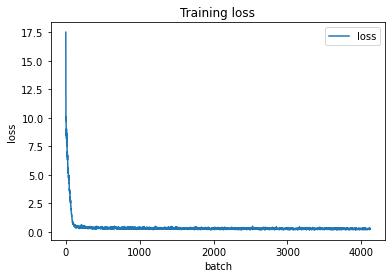

In [19]:
# paint training loss graph
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['loss'], loc='upper right')
plt.show()

### 模型存檔

In [20]:
import os

dir_path = r"./models/DGen/"
model_name = "RoBERTa_CLOTH_model1"

if not os.path.exists(dir_path):
  os.mkdir(dir_path)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(os.path.join(dir_path, model_name))

In [ ]:
del model
torch.cuda.empty_cache()

## 載入模型並初始化

* RoBERTa_CLOTH_model1: max_len=64, batch=64, epoch=1, learn rate=0.0001 

In [ ]:
questions = {
    "q1": {
        "sentence": "To make Jane live a <mask> life, Mother was very careful about spending money. </s> happy",
        "answer": "happy",
        "distractors": ["poor", "busy", "sad"]
    },
    "q2": {
        "sentence": "<mask> , Jane didn't understand her. </s> However",
        "answer": "However",
        "distractors": ["Though", "Although", "Or"]
    },
    "q3": {
        "sentence": "Every day Mother was busy with her <mask> while Jane was studying at school, so they had little time to enjoy themselves. </s> work",
        "answer": "work",
        "distractors": ["writing", "housework", "research"]
    },
    "q4": {
        "sentence": "One day, Mother realized Jane was unhappy and even <mask> to her. </s> unfriendly",
        "answer": "unfriendly",
        "distractors": ["loyal", "kind", "cruel"]
    },
    "q5": {
        "sentence": "The old man was waiting for a ride across the <mask> . </s> river",
        "answer": "river",
        "distractors": ["town", "country", "island"]
    },
    "q6": {
        "sentence": "I felt uncomfortable and out of place as the professor carefully <mask> what she expected us to learn. </s> explained",
        "answer": "explained",
        "distractors": ["showed", "designed", "offered"]
    },
    "q7": {
        "sentence": "As I listened, I couldn't help but <mask> of my own oldest daughter. </s> think",
        "answer": "think",
        "distractors": ["speak", "talk", "hear"]
    },
    "q8": {
        "sentence": "As we were <mask> on the third floor for old people with Alzheimer, most of them stared off at the walls or floor. </s> singing",
        "answer": "singing",
        "distractors": ["meeting", "gathering", "dancing"]
    },
    "q9": {
        "sentence": "As we got <mask> with each song, she did as well. </s> louder",
        "answer": "louder",
        "distractors": ["higher", "nearer", "faster"]
    },
    "q10": {
        "sentence": "Mr. Petri, <mask> injured in the fire, was rushed to hospital. </s> seriously",
        "answer": "seriously",
        "distractors": ["blindly", "hardly", "slightly"]
    },
    "q11": {
        "sentence": "If an object is attracted to a magnet, the object is most likely made of <mask>. </s> metal",
        "answer": "metal",
        "distractors": ["wood", "plastic", "cardboard"]
    },
    "q12": {
        "sentence": "the main organs of the respiratory system are <mask>. </s> lungs",
        "answer": "lungs",
        "distractors": ["ovaries", "intestines", "kidneys"]
    },
    "q13": {
        "sentence": "The products of photosynthesis are glucose and <mask> else. </s> oxygen",
        "answer": "oxygen",
        "distractors": ["carbon", "hydrogen", "nitrogen"]
    },
    "q14": {
        "sentence": "frogs have <mask> eyelid membranes. </s> three",
        "answer": "three",
        "distractors": ["two", "four", "one"]
    },
    "q15": {
        "sentence": "the only known planet with large amounts of water is <mask>. </s> earth",
        "answer": "earth",
        "distractors": ["saturn", "jupiter", "mars"]
    },
    "q16": {
        "sentence": "<mask> is responsible for erosion by flowing water and glaciers. </s> gravity",
        "answer": "gravity",
        "distractors": ["kinetic", "electromagnetic", "weight"],
    },
    "q17": {
        "sentence": "Common among mammals and insects , pheromones are often related to <mask> type of behavior. </s> reproductive",
        "answer": "reproductive",
        "distractors": ["aggressive", "immune", "cardiac"]
    },
    "q18": {
        "sentence": "<mask> can reproduce by infecting the cell of a living host. </s> virus",
        "answer": "virus",
        "distractors": ["bacteria", "mucus", "carcinogens"]
    },
    "q19": {
        "sentence": "proteins are encoded by <mask>. </s> genes",
        "answer": "genes",
        "distractors": ["DNA", "RNA", "codons"]
    },
    "q20": {
        "sentence": "Producers at the base of ecological food webs are also known as <mask>. </s> autotrophic",
        "answer": "autotrophic",
        "distractors": ["endoscopic", "symbiotic", "mutualistic"],
    },
    "q21": {
        "sentence": "Today morning, I saw a <mask> sitting on the wall. </s> cat",
        "answer": "cat",
        "distractors": [],
    },
    "q22": {
        "sentence": "Ukrainian presidential adviser says situation is ' <mask> control' in suburbs and outskirts of Kyiv. </s> under",
        "answer": "under",
        "distractors": [],
    },
    "q23": {
        "sentence": "I don't think that after what is <mask> now, Ukraine has weak positions. </s> happening",
        "answer": "happening",
        "distractors": [],
    },
}

In [ ]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch
import os

model_path = r"./models/DGen/RoBERTa_DGen_model1"

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForMaskedLM.from_pretrained(model_path)
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [ ]:
encoded_input = tokenizer(questions["q1"]["sentence"], return_tensors='pt')
output = model(**encoded_input)
print(output)

MaskedLMOutput(loss=None, logits=tensor([[[19.1455,  7.0534,  8.0423,  ..., -2.6507, -4.5790,  6.2753],
         [ 5.4315,  0.2601, 13.1666,  ..., -4.8737, -0.7431,  5.0738],
         [ 0.4423, -2.4593, 10.7037,  ..., -4.7449, -3.3855,  3.6422],
         ...,
         [-4.5917,  1.8428, 11.3261,  ..., -7.1226, -7.5788,  0.9754],
         [-1.7966, -0.1699, 12.6469,  ..., -5.0585, -7.3336,  3.6435],
         [ 0.9643,  2.2532, 13.5814,  ..., -5.1007, -6.3054,  4.3427]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)


### 我的

In [ ]:
from transformers import pipeline
my_unmasker = pipeline('fill-mask', tokenizer=tokenizer, model=model, top_k=10)

In [ ]:
my_unmasker(questions["q19"]["sentence"])

[{'score': 0.09780115634202957,
  'sequence': 'proteins are encoded by proteins.  genes',
  'token': 17792,
  'token_str': ' proteins'},
 {'score': 0.07206682115793228,
  'sequence': 'proteins are encoded by genes.  genes',
  'token': 14819,
  'token_str': ' genes'},
 {'score': 0.034579720348119736,
  'sequence': 'proteins are encoded by enzymes.  genes',
  'token': 35309,
  'token_str': ' enzymes'},
 {'score': 0.0311406459659338,
  'sequence': 'proteins are encoded by cells.  genes',
  'token': 4590,
  'token_str': ' cells'},
 {'score': 0.02436184324324131,
  'sequence': 'proteins are encoded by protein.  genes',
  'token': 8276,
  'token_str': ' protein'},
 {'score': 0.017512204125523567,
  'sequence': 'proteins are encoded by viruses.  genes',
  'token': 21717,
  'token_str': ' viruses'},
 {'score': 0.016495242714881897,
  'sequence': 'proteins are encoded by DNA.  genes',
  'token': 5708,
  'token_str': ' DNA'},
 {'score': 0.016130398958921432,
  'sequence': 'proteins are encoded b

In [ ]:
question_num = "q19"

sentence = questions[question_num]["sentence"]
answer = questions[question_num]["answer"].lower()
dis = [d.lower() for d in questions[question_num]["distractors"]]

cs1 = list()
for cand in my_unmasker(questions[question_num]["sentence"]):
    cs1.append(cand["token_str"].replace(" ", ""))

print(sentence)
print(answer)
print(dis)
print(cs1)

proteins are encoded by [MASK]. [SEP] genes
genes
['dna', 'rna', 'codons']
['proteins', 'genes', 'chromosomes', 'mutations', 'genomes', 'exons', 'molecules', 'nucleotides', 'enzymes', 'lipids']


### 原本的

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased', top_k=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
unmasker(text1)

[{'score': 0.29360201954841614,
  'sequence': 'to make jane live a normal life, mother was very careful about spending money. happy',
  'token': 3671,
  'token_str': 'normal'},
 {'score': 0.14251358807086945,
  'sequence': 'to make jane live a better life, mother was very careful about spending money. happy',
  'token': 2488,
  'token_str': 'better'},
 {'score': 0.1040932908654213,
  'sequence': 'to make jane live a good life, mother was very careful about spending money. happy',
  'token': 2204,
  'token_str': 'good'},
 {'score': 0.09106693416833878,
  'sequence': 'to make jane live a happy life, mother was very careful about spending money. happy',
  'token': 3407,
  'token_str': 'happy'},
 {'score': 0.03141509369015694,
  'sequence': 'to make jane live a simple life, mother was very careful about spending money. happy',
  'token': 3722,
  'token_str': 'simple'},
 {'score': 0.025173284113407135,
  'sequence': 'to make jane live a decent life, mother was very careful about spending mo

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')

## Test

In [ ]:
!pip install nltk
import nltk
nltk.download("abc")
from nltk.corpus import abc
nltk.download('punkt')

In [ ]:
import random
def random_mask(input_list):
  masked_list = list.copy(input_list)
  masked_list[random.randint(0, len(input_list)-1)]="<mask>"
  return masked_list

sentens_list = abc.sents()
input_sentences = [ " ".join(sen) for sen in sentens_list]
masked_sentences = [ " ".join(random_mask(sen)) for sen in sentens_list]

In [ ]:
print(input_sentences[:100])

In [ ]:
print(masked_sentences[:100])

## padding before dataset

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_encodings = tokenizer(inputs_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")
label_encodings = tokenizer(labels_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")

In [ ]:
print(input_encodings["input_ids"].shape)
print(label_encodings["input_ids"].shape)

In [ ]:
input_encodings.keys()

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(input_encodings.input_ids[index])))
print()
print(tokenizer.decode(input_encodings.input_ids[index]))
print()
print(input_encodings.attention_mask[index])

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(label_encodings.input_ids[index])))
print()
print(tokenizer.decode(label_encodings.input_ids[index]))
print()
print(label_encodings.attention_mask[index])

In [ ]:
import torch

class WNDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        input_ids = torch.tensor(self.encodings["input_ids"][index]).squeeze()
        labels = torch.tensor(self.labels["input_ids"][index]).squeeze()
        
        return {"input_ids": input_ids, "labels": labels}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = WNDataset(input_encodings, label_encodings)

In [ ]:
print(train_dataset[0])

In [ ]:
!nvidia-smi

Sat Feb 19 09:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------